# What is the perfect anatomy of a powerlifter?

With this project, I am trying to answer the question of what constitutes the perfect anatomy for a powerlifter. By anatomy, I mean the body composition, so ratio between the upper and lower body, upper and lower arms, upper and lower legs, etc. To this end, the anatomy of the 100 best female and male powerlifters in the world is analyzed and compared with their competition PRs.

## What is Powerlifting?

Powerlifting is a competitive strength sport that consists of three attempts at maximal weight on three lifts: squat, bench press, and deadlift.

Most powerlifting federations (including the International Powerlifting Federation IPF) use the following weight classes:
- Men: −53 kg (sub-junior/junior), −59 kg, −66 kg, −74 kg, −83 kg, −93 kg, −105 kg, −120 kg, 120 kg+
- Women: −43 kg (sub-junior/junior), −47 kg, −52 kg, −57 kg, −63 kg, −69 kg, −72 kg, −84 kg, 84 kg+

## How do I try to answer the question?

To answer the question of the perfect powerlifting anatomy, I use the cross-industry standard process for data mining model. [MediaPipe](https://github.com/google-ai-edge/mediapipe) is used to automatically extract body joints.

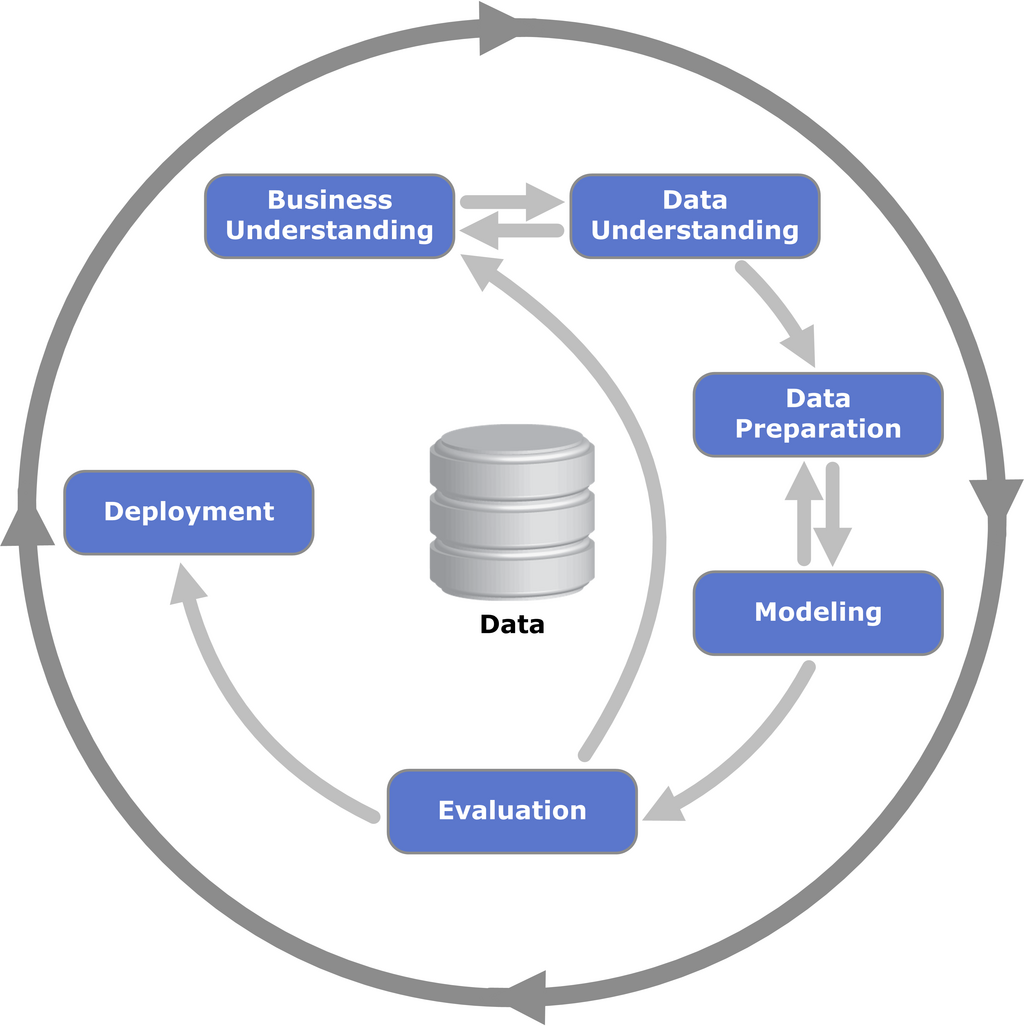

## Step 1 & 2: Business and Data Understanding

[Data source](https://openpowerlifting.gitlab.io/opl-csv/bulk-csv.html)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

image_path = "images/schreiner-lea.png"

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

results = pose.process(image_rgb)

if not results.pose_landmarks:
    print("No person found")
else:
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Gelenkpunkte")
    plt.show()

def get_pixel_coords(landmark, shape):
    h, w, _ = shape
    return int(landmark.x * w), int(landmark.y * h)

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

landmarks = results.pose_landmarks.landmark

shoulder_r = get_pixel_coords(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER], image.shape)
elbow_r = get_pixel_coords(landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW], image.shape)
wrist_r = get_pixel_coords(landmarks[mp_pose.PoseLandmark.RIGHT_WRIST], image.shape)

upper_arm_len = get_distance(shoulder_r, elbow_r)
lower_arm_len = get_distance(elbow_r, wrist_r)
arm_ratio = upper_arm_len / lower_arm_len

print(f"Oberarm-Länge: {upper_arm_len:.2f} px")
print(f"Unterarm-Länge: {lower_arm_len:.2f} px")
print(f"Verhältnis Oberarm : Unterarm = {arm_ratio:.2f}")

annotated_image_lines = annotated_image.copy()

cv2.line(annotated_image_lines, shoulder_r, elbow_r, (255, 0, 0), 3)
cv2.line(annotated_image_lines, elbow_r, wrist_r, (0, 255, 0), 3)

cv2.putText(annotated_image_lines, f"{upper_arm_len:.0f}px", 
            ((shoulder_r[0] + elbow_r[0]) // 2, (shoulder_r[1] + elbow_r[1]) // 2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

cv2.putText(annotated_image_lines, f"{lower_arm_len:.0f}px", 
            ((elbow_r[0] + wrist_r[0]) // 2, (elbow_r[1] + wrist_r[1]) // 2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image_lines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Längenmessung: Rechter Arm")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv('data/openpowerlifting-2025-05-03-c77c7449.csv')

print(df.head())

print(df.info())

print(df.describe(include='all'))

print(df.isnull().sum())

In [ ]:
# Top lifters by total weight lifted
top_lifters = df[df['TotalKg'].notnull()].sort_values(by='TotalKg', ascending=False).head(10)
print(top_lifters[['Name', 'Sex', 'TotalKg', 'WeightClassKg', 'Federation']])

# Average lifts by gender
avg_by_sex = df.groupby('Sex')[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']].mean()
print(avg_by_sex)

# Most common federations
print(df['Federation'].value_counts().head(10))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of TotalKg
sns.histplot(df['TotalKg'].dropna(), bins=50, kde=True)
plt.title("Distribution of TotalKg")
plt.xlabel("Total Weight Lifted (Kg)")
plt.show()

# Compare Dots scores by Equipment
sns.boxplot(x='Equipment', y='Dots', data=df[df['Dots'].notnull()])
plt.title("Dots Score by Equipment Type")
plt.xticks(rotation=45)
plt.show()